# 1. Autoencoder Implementation

## Describe your dataset and the steps that you used to create it
The original dataset consists of many images of emojis that are of size 256x256. I started by using the datasets library to download the emoji dataset from huggin face. After this, dataset needed to be augmented and split into training, validation, and test sets. The first augmentation step was to gather a subset of a the data based on the text in the label. We chose to use the text "face", which includes grinning face, winking face, etc. The gave us ~200 images to work with in total. We then split this set into training, validation, and test with a 60, 20, 20 split respectively using the train_test_split library from sklearn. The next augmentation that needed to be done was to create more data for each split. We created an augment_data function that applied PyTorch transformations to the data that randomly flipped the images, resized them to 3, 64, 64, and converted the images to tensors. We did this 5 times for each set that multiplying the number of images by 5. 

<center>
Original train set: 122, Augmented train set: 610
Original valid set: 41, Augmented valid set: 205
Original test set: 41, Augmented test set: 205
</center>

Finally, we created a loader for each set to easilt iterate through the images when passing them to our model.

## Provide a summary of your architecture
The architecture consists of 5 layers for the encoder and 5 layers for the decoder. We use a "hourglass" architecutre, as do most autoencoders. The first layer is the number of channels (3, RGB) to 128. We use Convolutional Layers to reduce the dimensions to a 2x2 using a kernel size of 3, stride of 2, and padding of 1 for each layer to eventually decrease the image to a 2x2. Then, that output is ran through the decoder, which uses `ConvTranspose2d` which is similar to the inverse of Conv2d. This layer expands the encoded input back into an output that follow the dimensions of the batch size, channels, width, and height. We then utilize these in the forward method of the AE model.

## Discuss and explain your design choices
At first, we were using linear layers, which are not as well suited for image inputs, so switching to Conv2d was essential. We started with an arbitrary number of layers and made sure to match the encoder to the decoder. The main challenge was making sure that input image size was matched by the output size. This took some trial and error, as well as calculating the kernel size, stride, and padding with this formula:

<center>
Output size = ((Input size + 2 * Padding - Kernel size) / Stride) + 1
</center>

For our training script, we made the mistake of making the learning rate too high which caused our model to not learn very well. After dropping the learning rate, the loss decreased quite nicely. Increasing the number of epochs also helped with decreasing the loss, as we found our model needed more time to reach a local minimum. 

## List Hyperparameters used in the model

Hyperparameters:
- Layer Type
- Number of input/ouput channels per layer
- Number of total layers
- Batch size
- Learning Rate
- Resize 
- Transformations
- Loss Function
- Weight Decay
- Optimizer
- Epochs

## Plot learning curves for training and validation loss as a function of training epochs

**Training**
<center>
<img src="loss_plots/loss_vs_iterations.png" alt="Alt text" width="600" height="300">
</center>

**Validation**
<div style="text-align:center">
<img src="loss_plots/validation_loss_vs_iterations.png" alt="Alt text" width="600" height="300">
</div>

## Provide the final average error of your autoencoder on your test set
The final average error was 2.73% on the test set.

## Provide a side-by-side example of 5 input and output images
<center>
<img src="output_plots/training/input_vs_output.png" alt="Alt text" width="500" height="250">
</center>

## Discuss any decisions or observations that you find relevant

c:\Users\Sharwin\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Sharwin\.cache\huggingface\hub\datasets--valhalla--emoji-dataset. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating train split: 100%|██████████| 2749/2749 [00:00<00:00, 4571.32 examples/s]


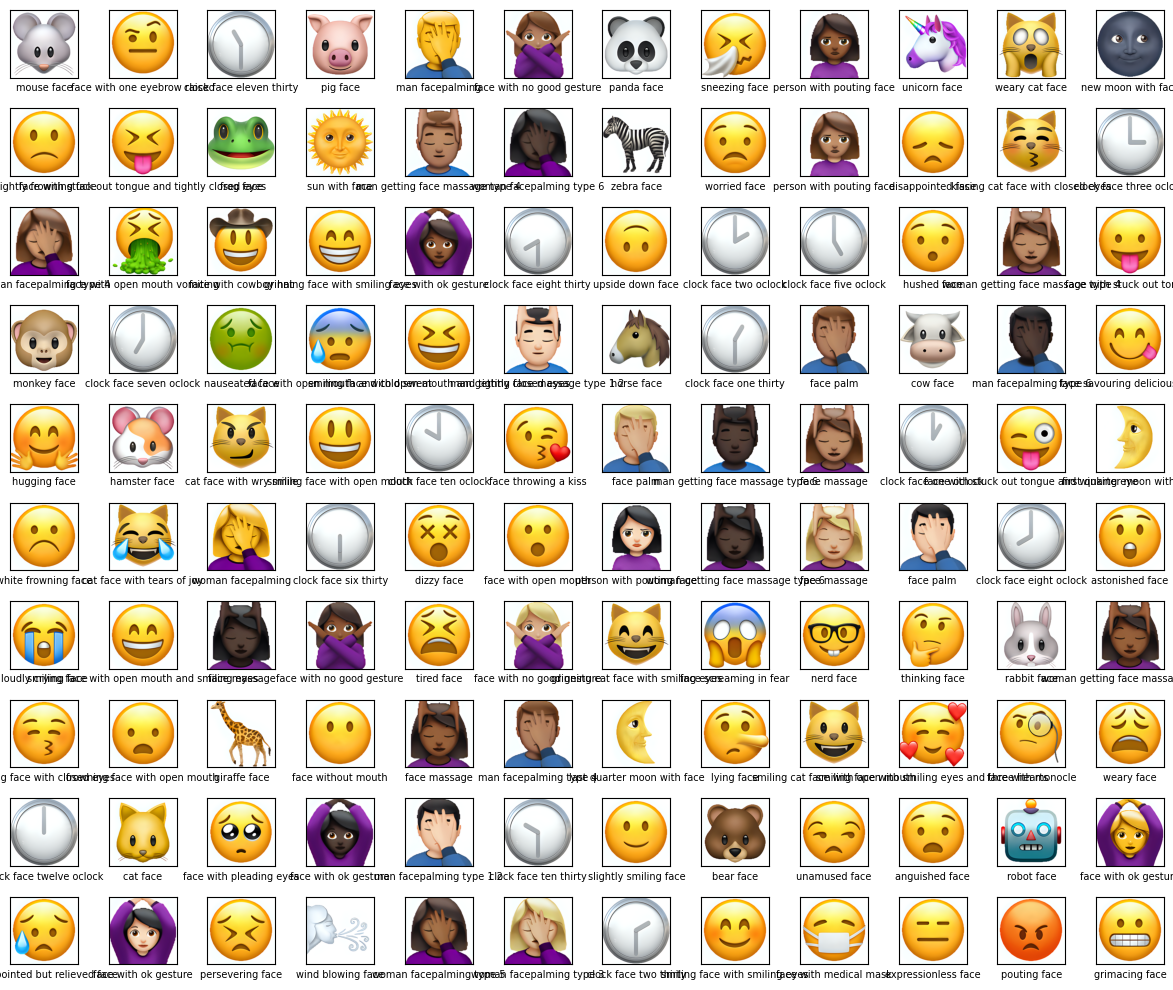

In [5]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
from model import AE
import matplotlib.pyplot as plt


dataset_split = []
train_set_augmented = []
valid_set_augmented = []
test_set_augmented = []

dataset = load_dataset("valhalla/emoji-dataset")

# Split data by text
for data in dataset["train"]:
    label = data["text"]
    if label.find("face") != -1:
        dataset_split.append(data)

# Split data into training, validation, and testing sets
train_set, temp_set = train_test_split(dataset_split, test_size=0.4)
test_set, valid_set = train_test_split(temp_set, test_size=0.5)

# Display images from the training set
num_images = len(train_set)
ncols = 12
nrows = num_images // ncols
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
axs = axs.flatten()
for ax, d in zip(axs, train_set):
    ax.imshow(d["image"])
    ax.set_xlabel(d["text"], fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axs[num_images:]:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [6]:
# Augmentation
transformations = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(30),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def augment_images(dataset):
    augmented_data = []
    for data in dataset:
        image = data["image"].convert("RGB")  # Convert to PIL Image
        for _ in range(5):  # Augment each image 5 times
            augmented_data.append(transformations(image))
    return augmented_data


# Apply augmentation
train_set_augmented = augment_images(train_set)
valid_set_augmented = augment_images(valid_set)
test_set_augmented = augment_images(test_set)

# Convert lists to tensors
train_set_augmented = torch.stack(train_set_augmented)
valid_set_augmented = torch.stack(valid_set_augmented)
test_set_augmented = torch.stack(test_set_augmented)

print(
    f"Original train set: {len(train_set)}, Augmented train set: {len(train_set_augmented)}")
print(
    f"Original valid set: {len(valid_set)}, Augmented valid set: {len(valid_set_augmented)}")
print(
    f"Original test set: {len(test_set)}, Augmented test set: {len(test_set_augmented)}")

Original train set: 122, Augmented train set: 610
Original valid set: 41, Augmented valid set: 205
Original test set: 41, Augmented test set: 205


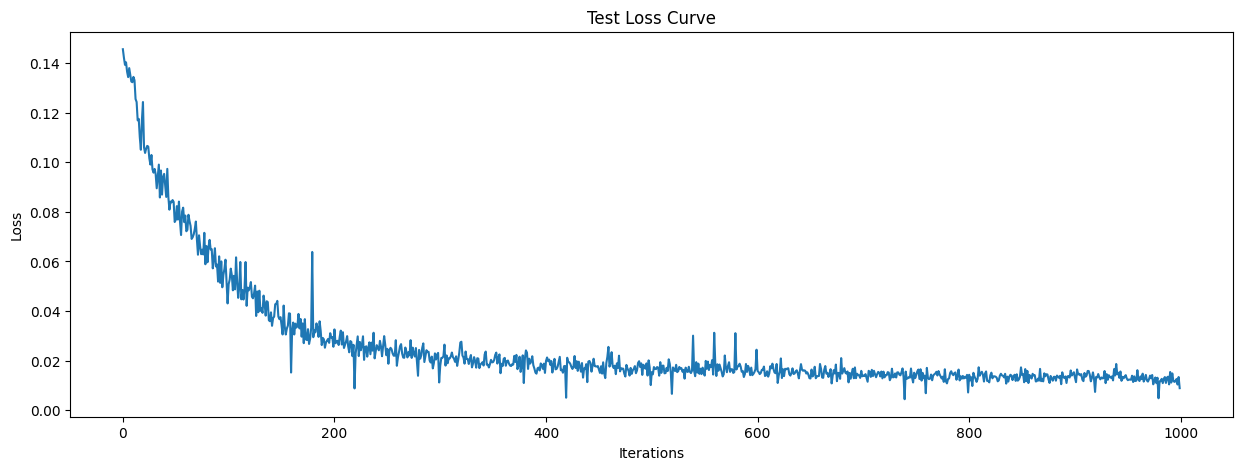

Average Loss on Test Set: 2.60%


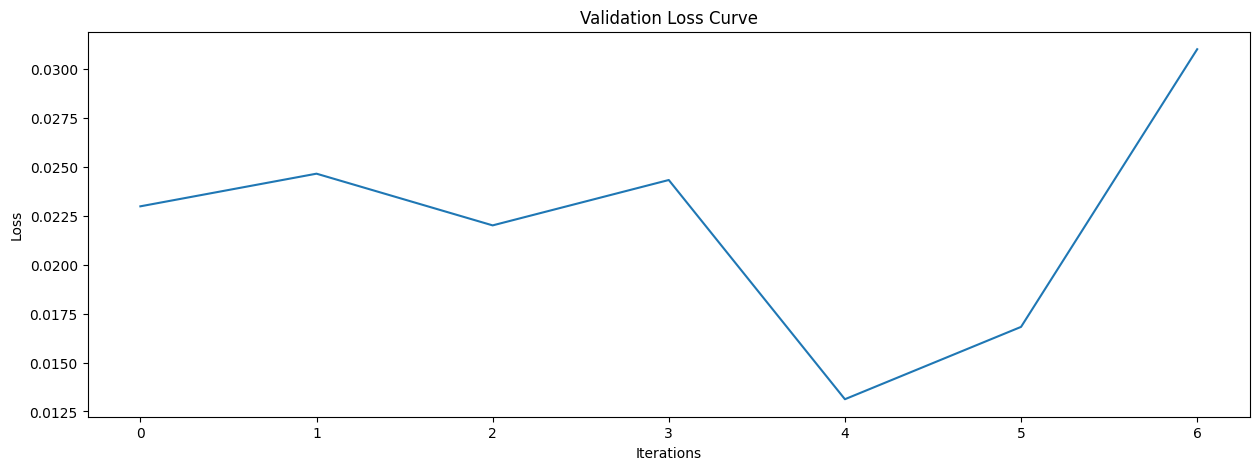

Using cpu device


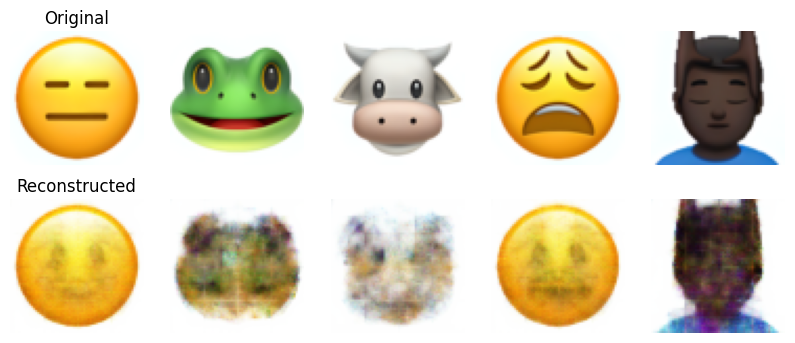

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_set_augmented,
                                           batch_size=32,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_set_augmented,
                                           batch_size=32,
                                           shuffle=False)

model = AE(input_width=64, input_height=64, num_channels=3)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001,
                             weight_decay=1e-8)

num_epochs = 50
losses = []
inputs = []
outputs = []
for epoch in range(num_epochs):
    for i, image in enumerate(train_loader):
        output_img = model(image)
        loss = loss_func(output_img, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Store the first batch of the last epoch for visualization
        if epoch == num_epochs - 1 and i == 0:
            inputs.append(image)
            outputs.append(output_img)

plt.figure(figsize=(15, 5))
plt.title("Test Loss Curve")
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.plot(losses)
plt.savefig("loss_plots/loss_vs_iterations")
plt.show()

# Record the final average error of our model on the test set
avg_loss = sum(losses) / len(losses)
print(f"Average Loss on Test Set: {avg_loss * 100:.2f}%")

valid_losses = []
for image in valid_loader:
    output_img = model(image)
    loss = loss_func(output_img, image)
    valid_losses.append(loss.item())
    
plt.figure(figsize=(15, 5))
plt.title("Validation Loss Curve")
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.plot(valid_losses)
plt.savefig("loss_plots/validation_loss_vs_iterations")
plt.show()

# Get a batch of images
image_batch = inputs[0]  # First batch of original images
output_batch = outputs[0]  # First batch of reconstructed images

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Detach and clamp values for visualization
image_batch = torch.clamp(image_batch.detach(), 0, 1)
output_batch = torch.clamp(output_batch.detach(), 0, 1)

n = 5
# Plot images side by side
fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))

for i in range(n):
    # Original Image
    axes[0, i].imshow(image_batch[i].permute(
        1, 2, 0).cpu().numpy())  # Convert to NumPy
    axes[0, i].axis("off")

    # Reconstructed Image
    axes[1, i].imshow(output_batch[i].permute(
        1, 2, 0).cpu().numpy())  # Convert to NumPy
    axes[1, i].axis("off")

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")

plt.savefig("output_plots/training/input_vs_output.png")
plt.show()

# 2. Separate dataset into 2 or more classes
## Describe how you separated your dataset into classes
The original dataset consisted of 256x256 emojis (images) with associated text which describes the image. We sorted through the dataset and sampled emojis which had the word "face" or "fist" appear in their description. After storing these emojis, we separated them into two classes based on the word "face" or "fist". All emojis corresponding to "fist" were assigned label 1, and all other face emojis were assigned label zero. After zipping and merging the images and their labels, I shuffled and split the data into training, validation and test sets. Additional augmentation was necesasay to increase the size of the dataset, since the "fist" emojis were very few in comparison to the "face" emojis.

## Describe your classification technique and hyper parameters
The classification technique involved using the output of the encoder network, flattening it into a single layer, and then use 2 `nn.Linear` layers along with ReLU and Dropout regularization. The last linear layer's ouput is the class logits. Cross entropy is used as a loss function for this classification task. The hyper parameters used are:
- Layer Type: nn.Linear (excluding the encoding layers)
- Number of input/ouput channels per layer: (32, 128) -> (128, 2)
- Number of total layers: 3 (excluding the encoding layers) 
- Batch size: 32
- Learning Rate: 0.001
- Resize: 64, 64
- Transformations: Resize, RandomHorizontalFlip
- Loss Function: Cross Entropy
- Weight Decay: 1e-5
- Optimizer: Adam
- Epochs: 50

## Plot learning curves for training and validation loss for MSE and classification accuracy
<center>
<img src="loss_plots/classifier/res.png">
</center>

## Provide a side by side example of 5 input and output images
<center>
<img src="output_plots/classifier/res.png">
</center>

## Discuss how incorporating classification as an auxillary task impact the performance of your autoencoder
By incorporating the classification as an auxillary task, the autoencoder seems to get better at extracting important features from the model bottleneck (encoder output). The classification loss makes it factor in the decision of predicting the correct label, while adjusting the weights involved in downsampling the image, thereby affecting the entire encoding decoding pipeline. However, in our case the model seems to overfit for the classification task, I believe this is due to the lack of diverse samples, especially for the fist set of images, but I still believe the performance should improve with the auxillary classification task.

## Speculate why the performance changed and recommend (but do not implement) an experiment to confirm or reject your speculation
The performance changed because the classification loss is added as a lambda factor into the total loss of the model. The weight given by the model to the classification task is a variable that can be changed using the lambda variable. This can serve as an important experiment to verify the model performance, as testing the model performance at different values of lambda, can serve as a metric to determine how the model weighs the classification and reconstruction tasks, and how one can affect the other.

In [8]:
# Lists to store the dataset, and extract the face and fist splits
dataset_split = []
face_split = []
fist_split = []

import random
from aux_model import AE_AUX

# Split data by text into face and fist samples
for data in dataset["train"]:
    label = data["text"]
    if label.find("face") != -1:
        dataset_split.append(data)
    elif label.find("fist") != -1:
        dataset_split.append(data)
        
# Increase fist samples, to make them equivalent to face samples
def augment_images(dataset, transform, target_size):
    augmented_data = []
    while len(augmented_data) < target_size:
        data = random.choice(dataset)
        image = data["image"].convert("RGB")
        augmented_data.append(transform(image))
    return augmented_data

face_split_transformed = augment_images(face_split, transformations, target_size=len(face_split) * 2)
fist_split_transformed = augment_images(fist_split, transformations, target_size=len(face_split) * 2)

# Store combined dataset into single list
dataset_split = face_split_transformed + fist_split_transformed

# Create labels based on length of transformed splits
labels = [0] * len(face_split_transformed) + [1] * len(fist_split_transformed)

# Split dataset into train, validation, and test sets
train_set, temp_set, train_labels, temp_labels = train_test_split(dataset_split, labels, test_size=0.4)
test_set, valid_set, test_labels, valid_labels = train_test_split(temp_set, temp_labels, test_size=0.5)

print(f"Train Set: ", len(train_set))
print(f"Validation Set: ", len(valid_set))
print(f"Test Set: ", len(test_set))

# Function to display images
def show_images(images, labels, title, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16)
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert tensor to HWC format
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

# Convert lists to tensors
train_set = torch.stack(train_set)
valid_set = torch.stack(valid_set)
test_set = torch.stack(test_set)

# Store image labels
train_labels = torch.tensor(train_labels, dtype=torch.long)
valid_labels = torch.tensor(valid_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# show_images(train_set, train_labels, "Training Set Samples")

train_loader = torch.utils.data.DataLoader(dataset=list(zip(train_set, train_labels)), batch_size=32, shuffle=True)

cls_lambda = 0.2
num_classes = 2
input_height = 64
input_width = 64
num_channels = 3

# Initialising the model parameters
model = AE_AUX(input_width, input_height, num_channels, num_classes, cls_lambda)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)

num_epochs = 50

valid_loader = torch.utils.data.DataLoader(dataset=list(zip(valid_set, valid_labels)), batch_size=32, shuffle=False)

def compute_loss(decoded_imgs, class_logits, target_imgs, target_labels, cls_lambda):
    ae_loss = torch.nn.functional.mse_loss(decoded_imgs, target_imgs)
    cls_loss = torch.nn.functional.cross_entropy(class_logits, target_labels)
    total_loss = ae_loss + cls_lambda * cls_loss
    return total_loss, ae_loss, cls_loss

train_ae_losses = []
train_cls_losses = []
val_ae_losses = []
val_cls_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training Loop
    model.train()
    epoch_ae_loss = 0.0
    epoch_cls_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        decoded_imgs, class_logits = model(images)
        total_loss, ae_loss, cls_loss = compute_loss(decoded_imgs, class_logits, images, labels, cls_lambda)

        total_loss.backward()
        optimizer.step()

        epoch_ae_loss += ae_loss.item()
        epoch_cls_loss += cls_loss.item()

    train_ae_losses.append(epoch_ae_loss / len(train_loader))
    train_cls_losses.append(epoch_cls_loss /len (train_loader))

    # Validation Loop
    model.eval()
    t_loss, t_ae_loss, t_cls_loss = 0.0, 0.0, 0.0
    correct, total = 0,0

    with torch.no_grad():
        for images, labels in valid_loader:
            
            decoded_imgs, class_logits = model(images)
            loss, ae_loss, cls_loss = compute_loss(decoded_imgs, class_logits, images, labels, cls_lambda)

            t_loss += loss.item()
            t_ae_loss += ae_loss.item()
            t_cls_loss += cls_loss.item()

            _, predicted = torch.max(class_logits.detach(), 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_ae_losses.append(t_ae_loss / len(valid_loader))
    val_cls_losses.append(t_cls_loss / len(valid_loader)) 
    accuracy = correct / total if total > 0 else 0
    val_accuracies.append(accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train AE Loss: {(epoch_ae_loss / len(train_loader)):.4f}, "
          f"Train CLS Loss: {(epoch_cls_loss / len(train_loader)):.4f}, "
          f"Val AE Loss: {(t_ae_loss / len(valid_loader)):.4f}, "
          f"Val CLS Loss: {(t_cls_loss / len(valid_loader)):.4f}, "
          f"Val Accuracy: {accuracy:.4f}")
    

plt.figure(figsize=(18, 6))

# MSE Loss Plot
plt.subplot(1, 3, 1)
plt.plot(train_ae_losses, label="Train MSE Loss", color='blue')
plt.plot(val_ae_losses, label="Validation MSE Loss", color='red', linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Learning Curve")
plt.legend()

# Classification Loss Plot
plt.subplot(1, 3, 2)
plt.plot(train_cls_losses, label="Train Classification Loss", color='blue')
plt.plot(val_cls_losses, label="Validation Classification Loss", color='red', linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Classification Learning Curve")
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("loss_plots/classifier/loss_vs_epochs.png")
plt.show()

model.eval()
with torch.no_grad():
    images, labels = next(iter(valid_loader))
    reconstructed, class_logits = model(images)

    # Convert predictions to class labels
    predicted_labels = torch.argmax(class_logits, dim=1)

# Display first 5 images
n = 5
fig, axes = plt.subplots(3, n, figsize=(n * 2, 6))

for i in range(n):
    # Original Image
    axes[0, i].imshow(images[i].cpu().permute(1, 2, 0).numpy())
    axes[0, i].axis("off")

    # Reconstructed Image
    axes[1, i].imshow(reconstructed[i].cpu().permute(1, 2, 0).numpy())
    axes[1, i].axis("off")

    # True vs Predicted Labels
    axes[2, i].text(0.5, 0.5, f"True: {labels[i].item()}\nPred: {predicted_labels[i].item()}",
                    fontsize=12, ha='center', va='center')
    axes[2, i].axis("off")

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
axes[2, 0].set_title("Labels")

plt.tight_layout()
plt.savefig("output_plots/classifier/classifier_test_input_vs_output.png")
plt.show()


ValueError: With n_samples=0, test_size=0.4 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

# 3. Attribute Composition

## Specify which attribute you selected, the vector arithmetic applied and the resulting image(s)
We chose to use the sunglasses attribute and combine it with a smiling face. We subtracted smiling face from smiling with sunglasses to retain the sunglasses attribute, and then added the image of the hugging face to give the hugging face sunglasses.

## Provide a qualitative evaluation of your composite image
The composite image is really blurry and doesn't maintain a lot of the features of the original images. The hands and sunglasses can be seen being combined into the final image, and is especially noticeable in the sunglasses with the black color that contrasts the emoji's yellow face. Despite the quality not being great, the image does blend the 2 features together successfully.

## Discuss ways to improve the quality of your generated image
The autoencoder decoder could be improved with more layers and/or tuning the layer sizes. When encoding the image, the model could be more complex to capture more features. Increasing the resolution of the images from (64x64x3) to something larger would preserve a bit more information since the latent representation produced from the decoder already loses some information.

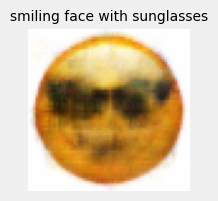

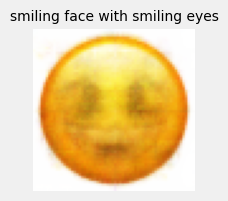

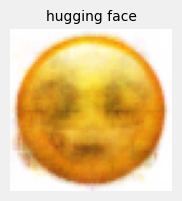

Composite Image: "smiling face with sunglasses" - "smiling face with smiling eyes" + "hugging face"


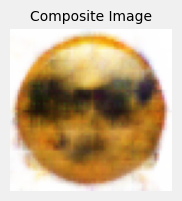

In [ ]:
# Select an attribute from the emoji dataset
# (internal or external to your selected subset)
# to compose with any image from your selected subset.
# Use vector arithmetic on latent representations to generate
# a composite image that expresses the attribute.

combined_set = train_set + valid_set + test_set

def get_image(text: str):
  # Returns the latent representation of the image corresponding to the text
  image = next(data for data in combined_set if data["text"] == text)["image"]
  # Convert images to tensors and move to device
  image = transformations(image).unsqueeze(0).to(device)
  # Encode the images to get the latent representations
  return model.encoder(image).detach()

def tensor_to_image(tensor: torch.Tensor):
  return tensor.permute(1, 2, 0).numpy()

# Get the latent representations of the images to be composited
image_names = ["smiling face with sunglasses", "smiling face with smiling eyes", "hugging face"]
image1, image2, image3 = [get_image(name) for name in image_names]

# Perform vector arithmetic to get the composite image
composite_latent = image1 - image2 + image3

# Decode the composite latent representation to show the composite image
composite_image = model.decoder(composite_latent).detach().cpu()

def display_image(img: torch.Tensor, title: str):
  plt.figure(figsize=(2, 2))
  plt.imshow(tensor_to_image(img[0].cpu()), cmap="gray" if img.shape[1] == 1 else None)
  plt.title(title, fontsize=10)
  plt.axis("off")

  plt.show()

display_image(model.decoder(image1).detach(), image_names[0])
display_image(model.decoder(image2).detach(), image_names[1])
display_image(model.decoder(image3).detach(), image_names[2])
print(f'Composite Image: "{image_names[0]}" - "{image_names[1]}" + "{image_names[2]}"')
display_image(composite_image, "Composite Image")